In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = sc.read_h5ad("../nCoV_dataset_full.h5ad")

       n_genes_by_counts  total_counts
count       46022.000000  46022.000000
mean          814.039959   1774.544597
std           429.381440    408.142982
min           298.000000    780.045361
25%           559.000000   1489.566982
50%           717.000000   1726.779466
75%           946.000000   2012.330623
max          5993.000000   4213.337036
       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count       46022.000000  46022.000000     46022.000000   46022.000000
mean          814.039959   1774.544597        20.537330       1.155392
std           429.381440    408.142982        10.133948       0.560477
min           298.000000    780.045361         0.000000       0.000000
25%           559.000000   1489.566982        12.681962       0.760052
50%           717.000000   1726.779466        20.010315       1.078060
75%           946.000000   2012.330623        27.662197       1.485755
max          5993.000000   4213.337036        60.184846       4.877690


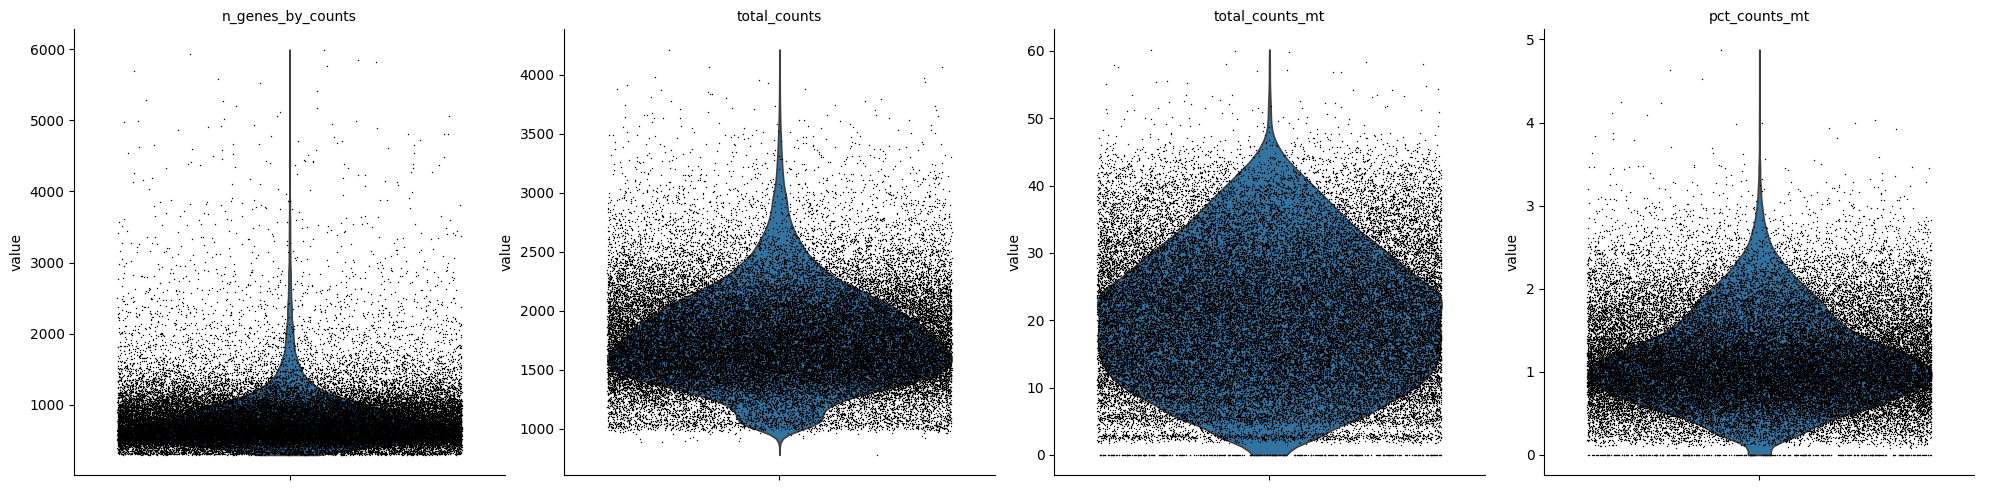

In [2]:
adata.var_names_make_unique()

# 2. Identify mitochondrial genes (human convention is "MT-")
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# 3. Compute QC metrics and store them in adata.obs
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

# Describe cells and genes:
print(adata.obs[["n_genes_by_counts", "total_counts"]].describe())

# 4. Confirm new metrics are added
print(adata.obs[["n_genes_by_counts", "total_counts", "total_counts_mt", "pct_counts_mt"]].describe())

# 5. Violin plots of these metrics across all cells
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)


In [3]:
# Calculating gene and count thresholds to apply outlier filtering

gene_stats = adata.obs['n_genes_by_counts'].describe()
count_stats = adata.obs['total_counts'].describe()

mean_genes = gene_stats['mean']
std_genes = adata.obs['n_genes_by_counts'].std()

mean_counts = count_stats['mean']
std_counts = adata.obs['total_counts'].std()

min_genes = max(mean_genes - 2 * std_genes, 300)
max_genes = mean_genes + 2 * std_genes

min_counts = max(mean_counts - 2 * std_counts, 500)
max_counts = mean_counts + 2 * std_counts

print(f"min_genes = {min_genes:.1f}, max_genes = {max_genes:.1f}")
print(f"min_counts = {min_counts:.1f}, max_counts = {max_counts:.1f}")

min_genes = 300.0, max_genes = 1672.8
min_counts = 958.3, max_counts = 2590.8


Original number of cells: 46022
Original number of genes: 18824
Original matrix sparsity: 0.9568
Cells removed (fewer than 300 genes): 3
Genes removed (expressed in <10 cells): 2282
Cells removed (mito % > 25): 0
Cells removed (extreme outliers): 2086
Cells removed (low total counts): 20
Filtered matrix sparsity: 0.9548
Final number of cells: 43913
Final number of genes: 16542


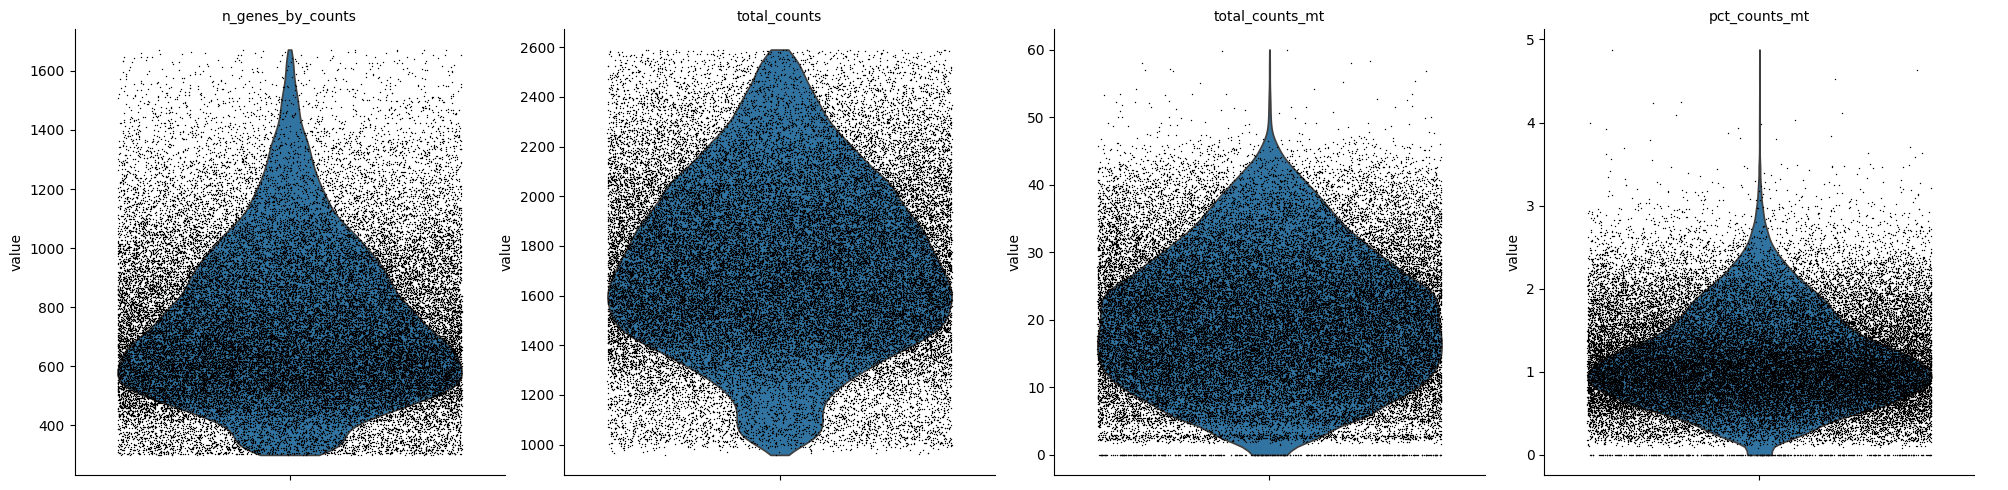

In [5]:
import numpy as np

# Print number of cells and genes before filtering
print(f"Original number of cells: {adata.n_obs}")
print(f"Original number of genes: {adata.n_vars}")

# Find sparsity.
sparsity = 1 - (np.sum(adata.X != 0) / np.prod(adata.shape))
print(f"Original matrix sparsity: {sparsity:.4f}")

# Filter cells with <300 genes.
initial_n_cells = adata.n_obs
sc.pp.filter_cells(adata, min_genes=300)
filtered_cells_b = initial_n_cells - adata.n_obs
print(f"Cells removed (fewer than 300 genes): {filtered_cells_b}")

# Filter genes not expressed in > 10 cells.
initial_n_genes = adata.n_vars
sc.pp.filter_genes(adata, min_cells=10)
filtered_genes_c = initial_n_genes - adata.n_vars
print(f"Genes removed (expressed in <10 cells): {filtered_genes_c}")

# Filter cells with >25% mitochondrial content.
initial_n_cells_d = adata.n_obs
mito_filter = adata.obs['pct_counts_mt'] < 25
adata = adata[mito_filter].copy()
filtered_cells_d = initial_n_cells_d - adata.n_obs
print(f"Cells removed (mito % > 25): {filtered_cells_d}")

# Remove extreme outliers.
initial_n_cells_e = adata.n_obs
extreme_filter = (
    (adata.obs['n_genes_by_counts'] <= max_genes) &
    (adata.obs['total_counts'] <= max_counts)
)
adata = adata[extreme_filter].copy()
filtered_cells_e = initial_n_cells_e - adata.n_obs
print(f"Cells removed (extreme outliers): {filtered_cells_e}")

# Remove low-quality cells.
initial_n_cells_f = adata.n_obs
low_quality_filter = (
    (adata.obs['n_genes_by_counts'] >= min_genes) &
    (adata.obs['total_counts'] >= min_counts)
)
adata = adata[low_quality_filter].copy()
filtered_cells_f = initial_n_cells_f - adata.n_obs
print(f"Cells removed (low total counts): {filtered_cells_f}")

# Calculate new sparsity.
new_sparsity = 1 - (np.sum(adata.X != 0) / np.prod(adata.shape))
print(f"Filtered matrix sparsity: {new_sparsity:.4f}")

# Print number of cells and genes after filtering
print(f"Final number of cells: {adata.n_obs}")
print(f"Final number of genes: {adata.n_vars}")

# Plot QC metrics after filtering. 
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

In [4]:
from utils import observe_condition, observe_cell_types

observe_condition(adata)
observe_cell_types(adata)

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Now scale per gene
sc.pp.scale(adata, max_value=10)

In [6]:
print(adata.var_names)

Index(['RP11-34P13.7', 'RP11-34P13.8', 'FO538757.2', 'AP006222.2',
       'RP11-206L10.9', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17', 'ISG15',
       ...
       'IGLV5-52', 'RFPL1', 'RP1-101G11.3', 'CARD10', 'C22orf23',
       'CTA-223H9.9', 'RP6-109B7.2', 'RP6-109B7.4', 'FAM19A5', 'TRPM2-AS'],
      dtype='object', length=18824)


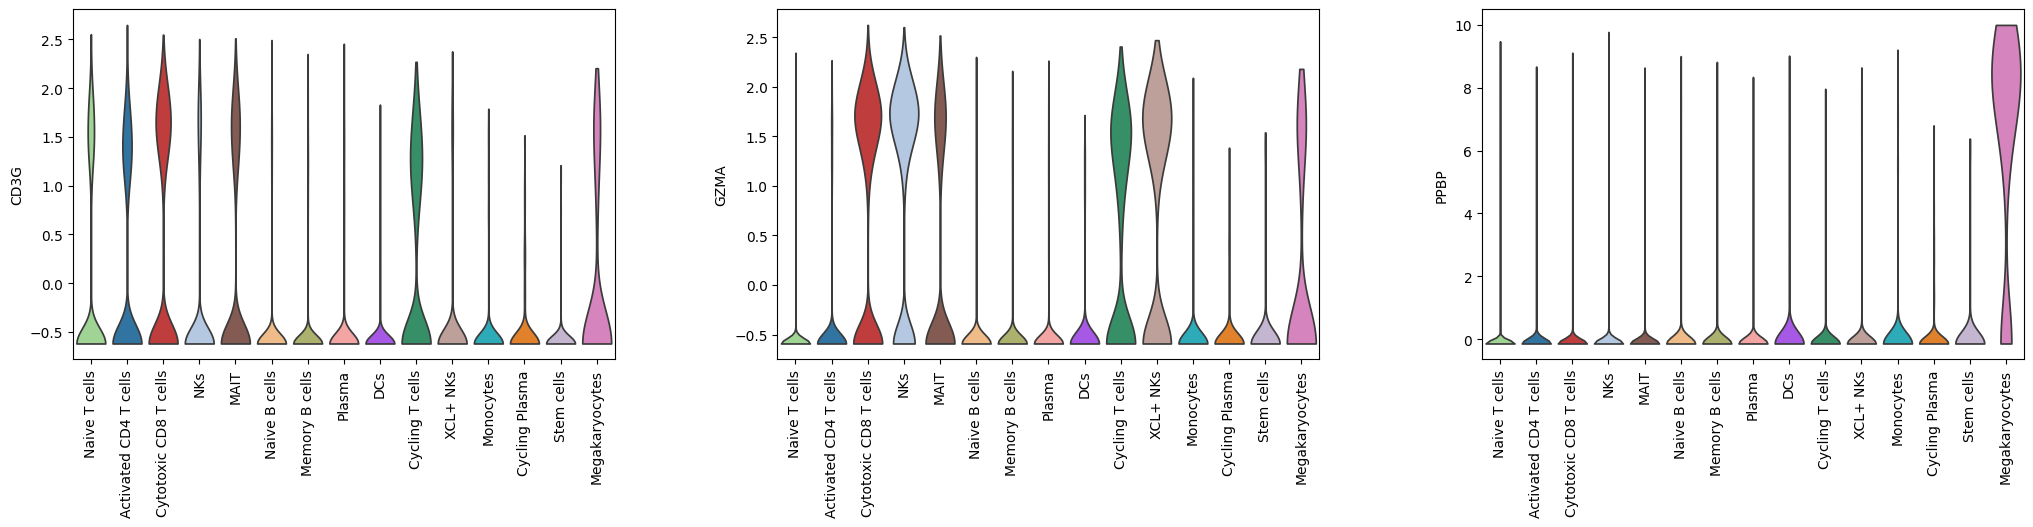

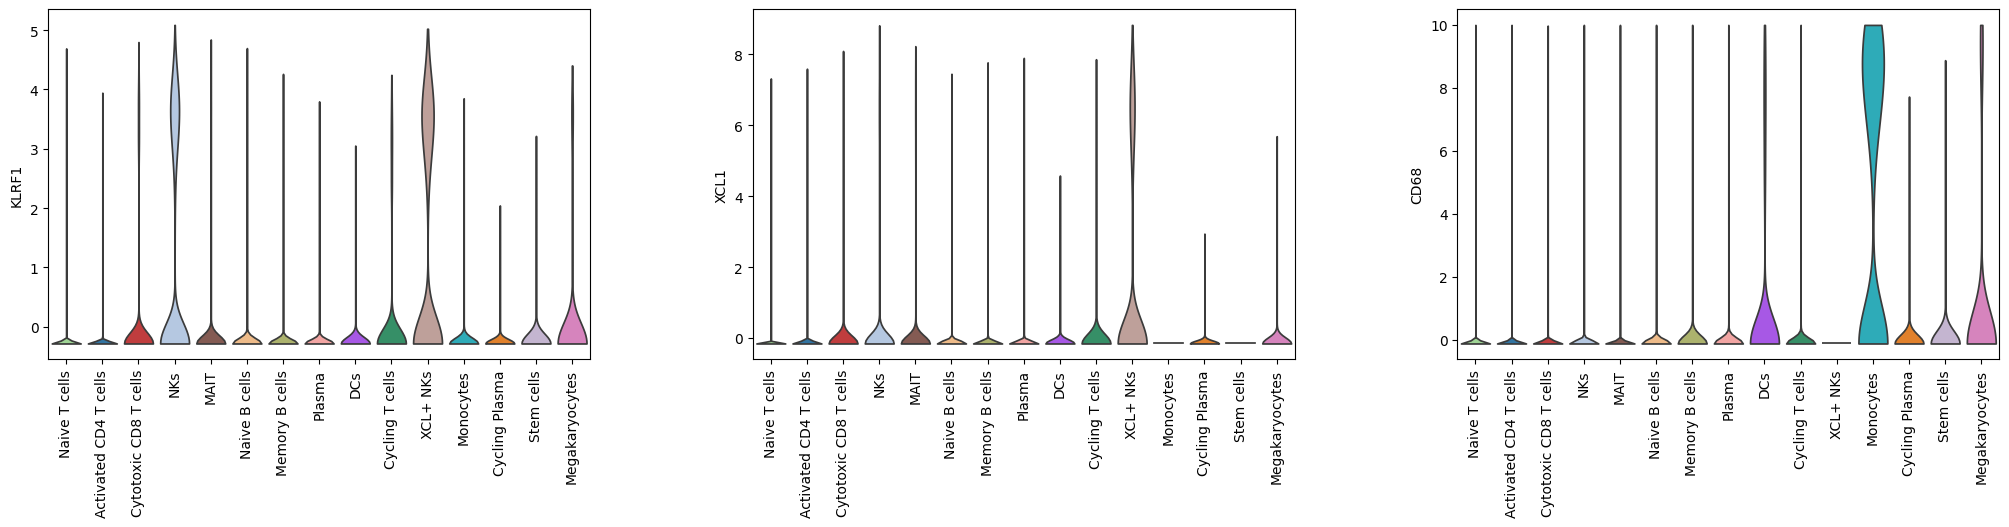

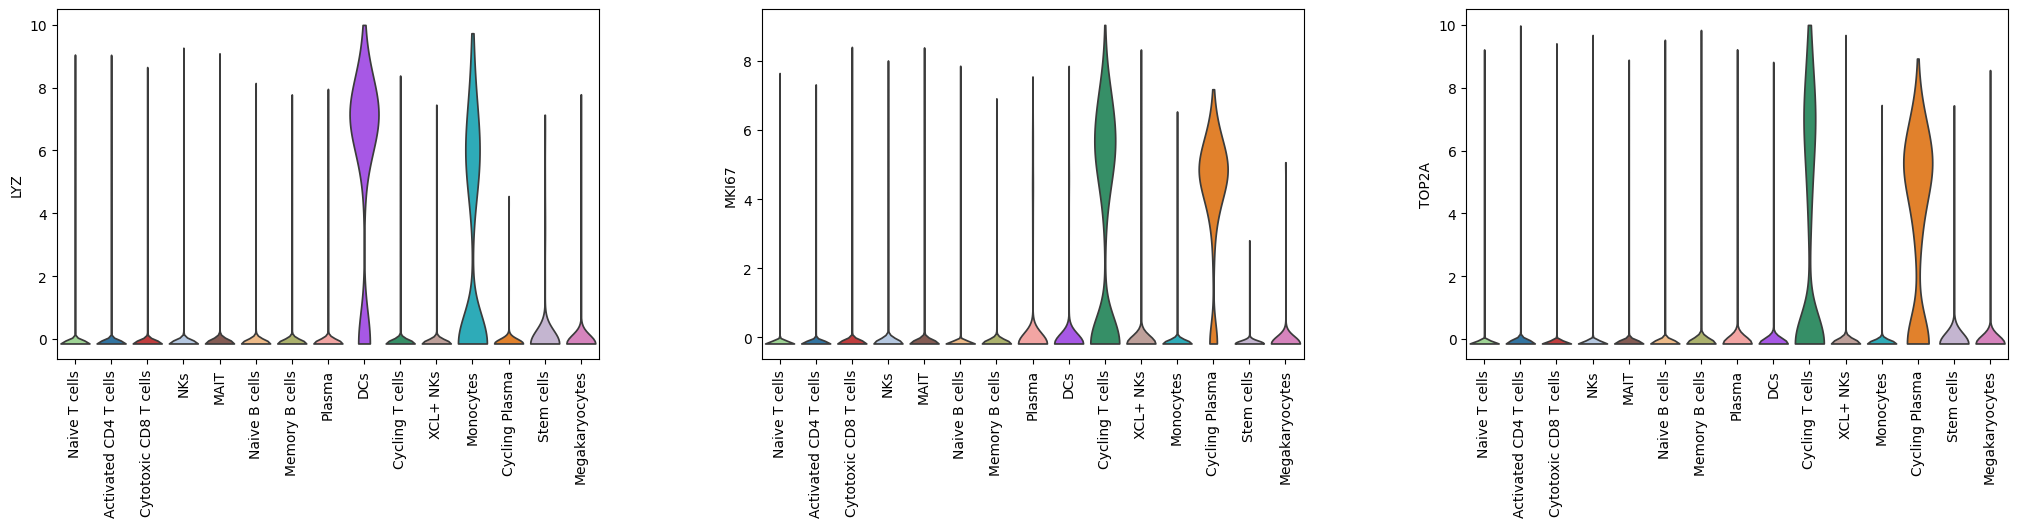

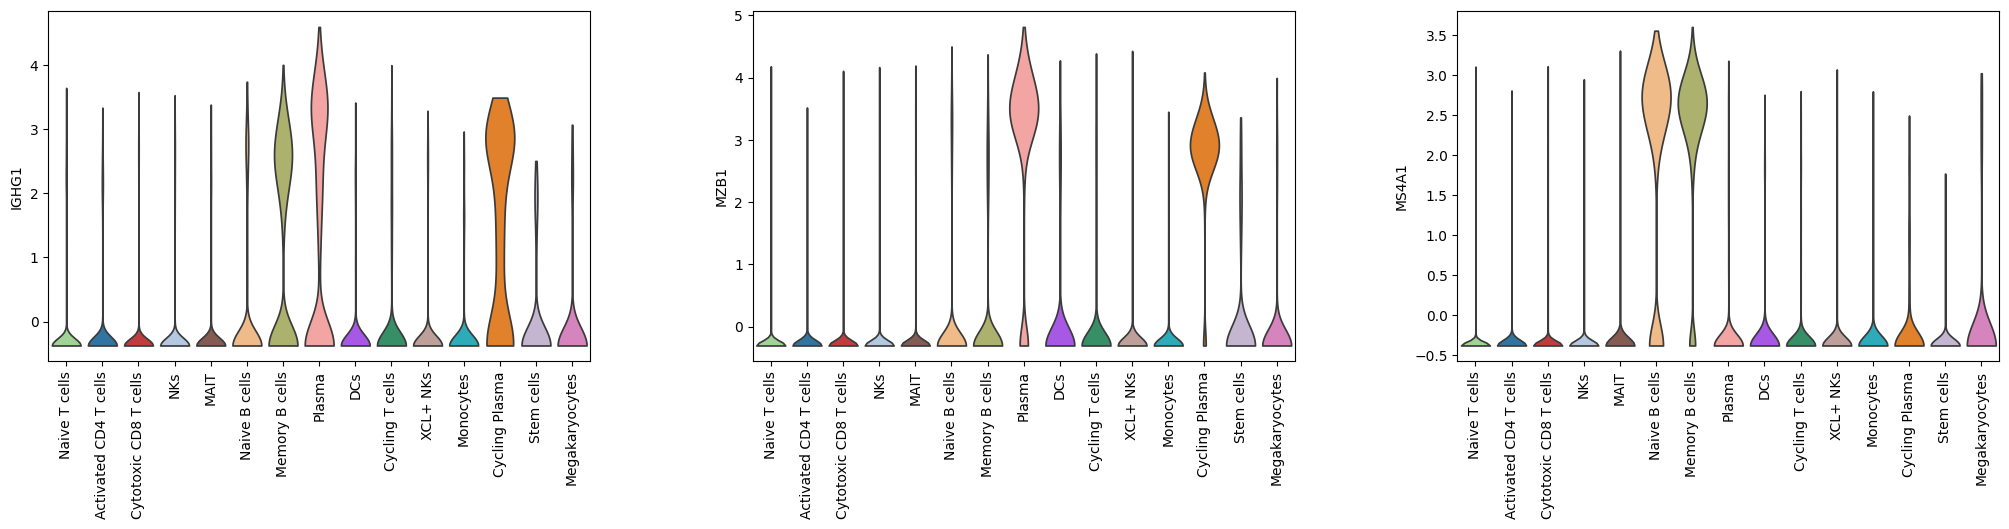

In [9]:
import math

marker_genes = ["CD3G", "GZMA", "PPBP", "KLRF1", "XCL1", "CD68", 
                "LYZ", "MKI67", "TOP2A", "IGHG1", "MZB1", "MS4A1"]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

marker_gene_indices = [str(gene_to_index[g]) for g in marker_genes]

ncols = 3
nrows = math.ceil(len(marker_genes) / ncols)



# Plot manually in subgroups
for i in range(nrows):
    start = i * ncols
    end = (i+1) * ncols
    subset_genes = marker_genes[start:end]
    
    sc.pl.violin(
        adata,
        keys=subset_genes,
        # log=True,
        groupby="cell_type_name",
        order=[
            "Naive T cells",
            "Activated CD4 T cells",
            "Cytotoxic CD8 T cells",
            "NKs",
            "MAIT",
            "Naive B cells",
            "Memory B cells",
            "Plasma",
            "DCs",
            "Cycling T cells",
            "XCL+ NKs",
            "Monocytes",
            "Cycling Plasma",
            "Stem cells",
            "Megakaryocytes"
        ],
        stripplot=False,
        multi_panel=True,
        rotation=90,
        jitter=0.4,
        size=1.5,
        use_raw=False,
    )

In [11]:
sc.pp.filter_cells(adata, min_genes=600)

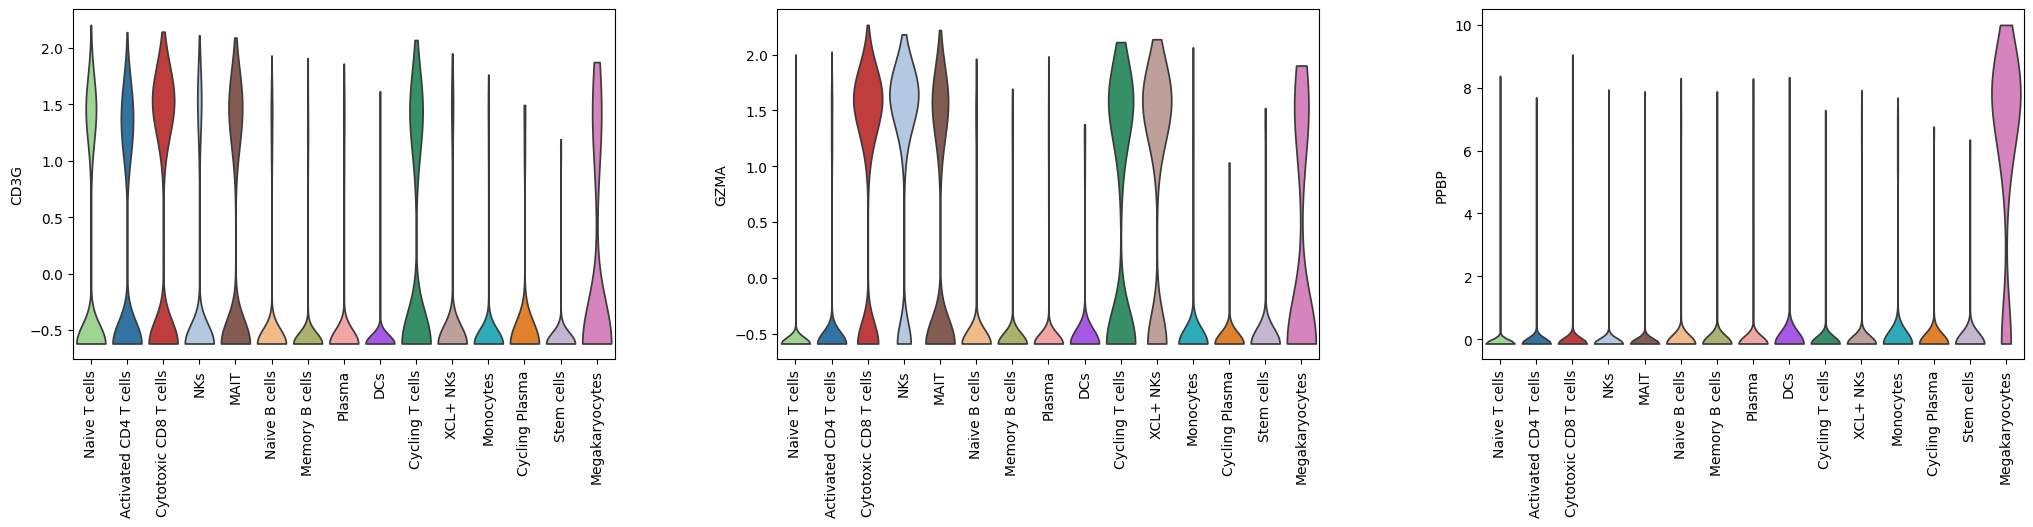

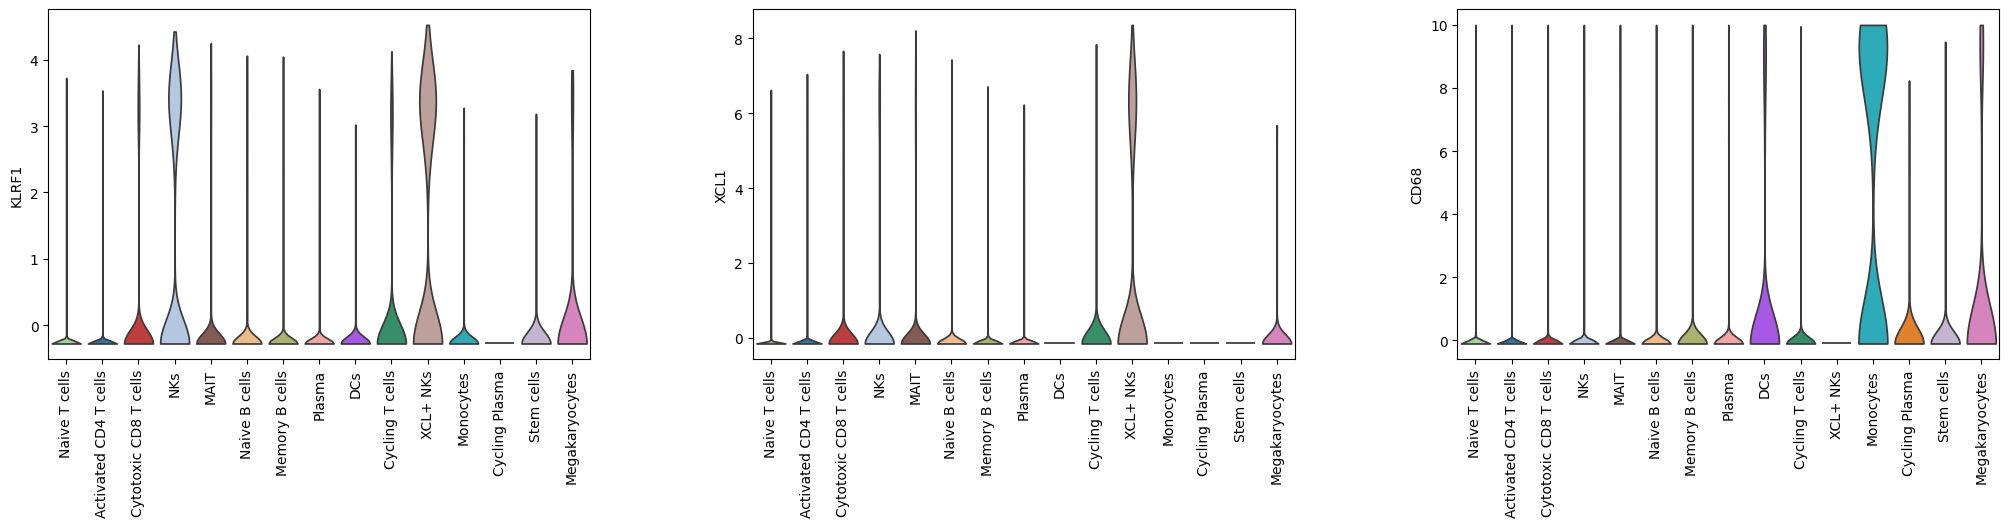

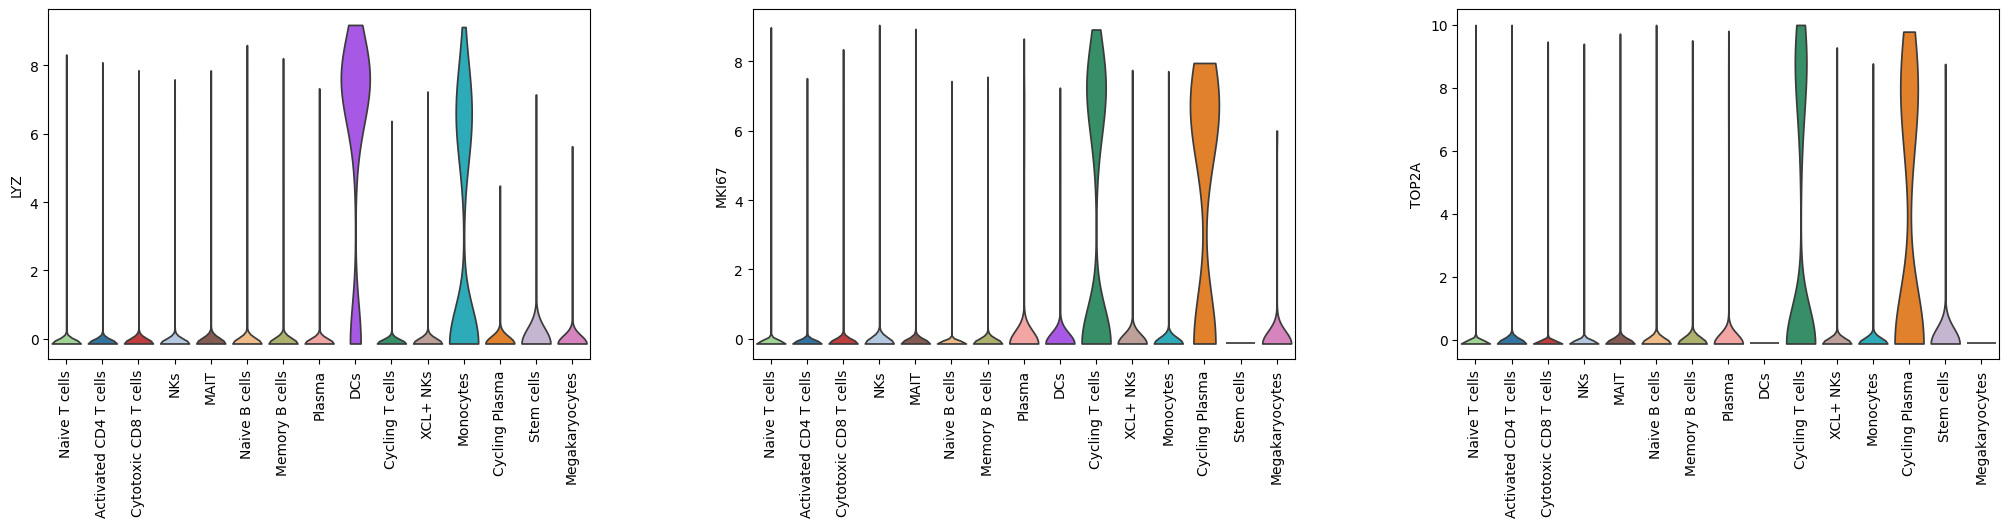

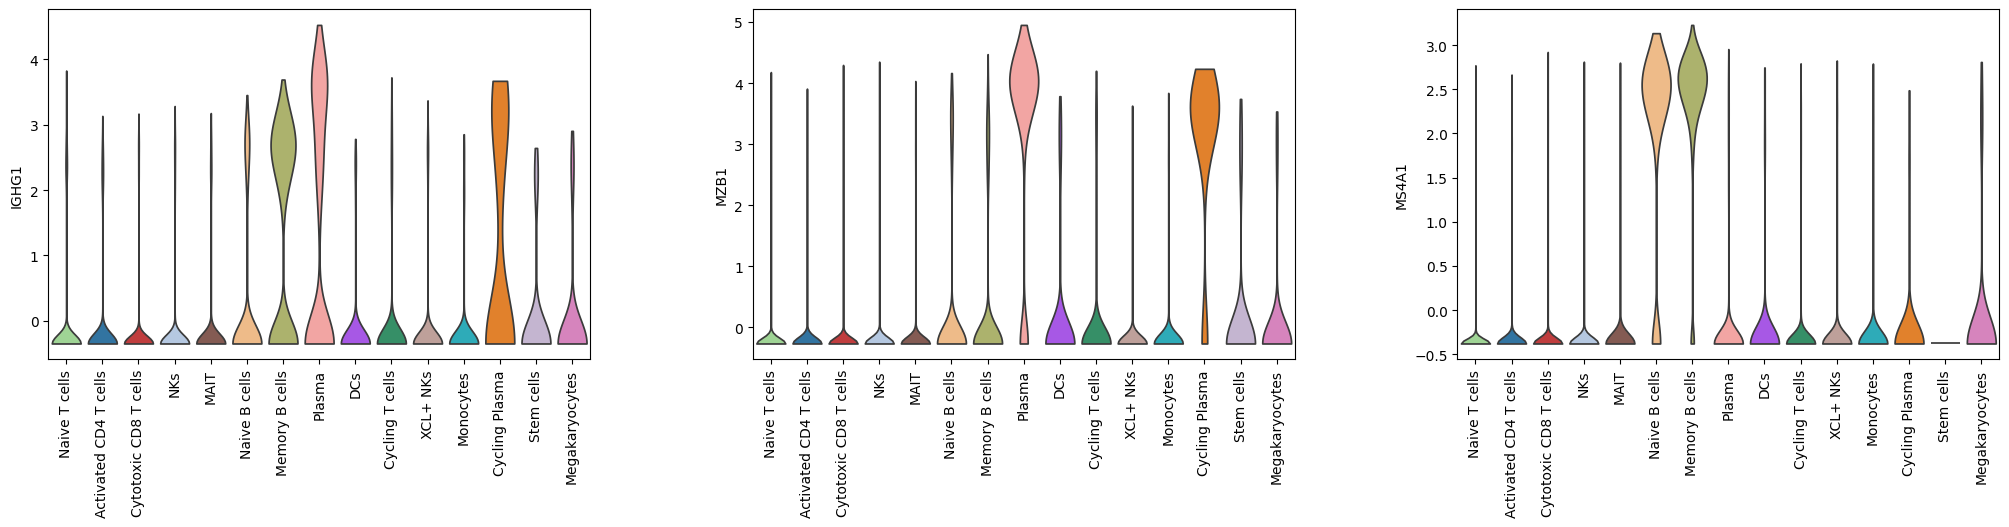

In [12]:
import math

marker_genes = ["CD3G", "GZMA", "PPBP", "KLRF1", "XCL1", "CD68", 
                "LYZ", "MKI67", "TOP2A", "IGHG1", "MZB1", "MS4A1"]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

marker_gene_indices = [str(gene_to_index[g]) for g in marker_genes]

ncols = 3
nrows = math.ceil(len(marker_genes) / ncols)



# Plot manually in subgroups
for i in range(nrows):
    start = i * ncols
    end = (i+1) * ncols
    subset_genes = marker_genes[start:end]
    
    sc.pl.violin(
        adata,
        keys=subset_genes,
        # log=True,
        groupby="cell_type_name",
        order=[
            "Naive T cells",
            "Activated CD4 T cells",
            "Cytotoxic CD8 T cells",
            "NKs",
            "MAIT",
            "Naive B cells",
            "Memory B cells",
            "Plasma",
            "DCs",
            "Cycling T cells",
            "XCL+ NKs",
            "Monocytes",
            "Cycling Plasma",
            "Stem cells",
            "Megakaryocytes"
        ],
        stripplot=False,
        multi_panel=True,
        rotation=90,
        jitter=0.4,
        size=1.5,
        use_raw=False
    )